<a href="https://colab.research.google.com/github/nitaifingerhut/cs236608/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


IDs:
* 302919402
* 204030720

In [1]:
import abc

class UserModel(abc.ABC):
  @abc.abstractclassmethod
  def utility(self, X, *args):
    raise NotImplementedError()
  
  def choice(self, X, *args):
    raise NotImplementedError()

## Q1

In [2]:
import numpy as np

class CompromiseUserModel(UserModel):
  def __init__(self, beta: np.ndarray, alpha: float):
    self.beta = beta
    self.alpha = alpha

  def _com(self, X: np.ndarray) -> np.ndarray:
    N, Q = X.shape  # (#items, #features)
    r = (np.min(X, axis=0, keepdims=True) + np.max(X, axis=0, keepdims=True)) / 2
    # r = np.expand_dims(r, 0)
    # r = np.repeat(r, N, axis=0)
    com = -np.linalg.norm(X - r, ord=2, axis=1)
    return com

  def utility(self, X: np.ndarray, *args) -> np.ndarray:
    M, N, Q = X.shape  # (#sets, #items, #features)
    v = np.zeros((M, N))
    for m in range(M):
      v[m, :] = X[m] @ self.beta + self.alpha * self._com(X[m])
    return v
  
  def choice(self, X: np.ndarray, *args) -> np.ndarray:
    M, N, Q = X.shape  # (#sets, #items, #features)
    choice = np.argmax(self.utility(X, *args), axis=1)
    return choice

### Unitest 

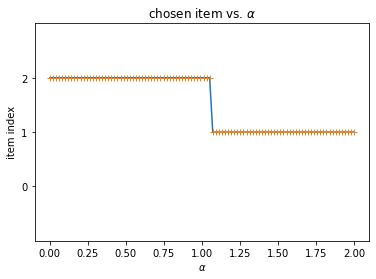

In [3]:
import matplotlib.pyplot as plt


cameras_ds = np.asarray([[[1, 1], [2, 2], [3, 3]]])  # features = (price, quality)
num_items, num_features = cameras_ds.shape[1:]

_, ax = plt.subplots()

beta = np.random.rand(num_features)
alpha_vec = np.linspace(0, 2, 100)

c = []
for alpha in alpha_vec:
  model = CompromiseUserModel(beta, alpha)
  c.append(model.choice(cameras_ds))

ax.plot(alpha_vec, c)
ax.plot(alpha_vec, c, '+')
ax.set(xlabel=r"$\alpha$", ylabel="item index", title=r"chosen item vs. $\alpha$")
ax.set_ylim([-1, num_items])
ax.set_yticks([i for i in range(num_items)])
ax.set_yticklabels([str(i) for i in range(num_items)])
plt.show()

### Test with given data

In [4]:
import pickle

with open ('users_validation (1).pkl', 'rb') as f:
  user_validation = pickle.load(f)

In [5]:
X = np.stack(user_validation['input_list'], axis=0)
y = np.asarray(user_validation['comp_selections'])

model = CompromiseUserModel(beta=np.arange(X.shape[2]), alpha=100)
y_pred = model.choice(X)
acc = np.sum(y_pred == y) / np.prod(y.shape)
print(f"accuracy = {acc}")

accuracy = 1.0


###Q2

In [6]:
np.random.seed(0)

In [7]:
def transform_pairwise(X: np.ndarray, y: np.ndarray):
  N, Q = X.shape
  K = N - 1
  Xy = X[y]
  X = np.delete(X, obj=y, axis=0)

  ynew = np.random.choice([-1, 1], size=(K, ))
  Xnew = np.expand_dims(ynew, 1) * (Xy - X)

  return Xnew, ynew

In [8]:
from sklearn import svm

class MyRanker(svm.LinearSVC):
  def shape_transform (self, X, y):
    M, N, Q = X.shape
    K = N - 1

    Xnew, ynew = [], []
    for m in range(M):
      Xnew_, ynew_ = transform_pairwise(X[m], y[m])
      Xnew.append(Xnew_)
      ynew.append(ynew_)
    
    Xnew = np.concatenate(Xnew)
    ynew = np.concatenate(ynew)
    
    return Xnew, ynew
  
  def fit(self, X, y):
    Xnew, ynew = self.shape_transform(X, y)
    super().fit(Xnew, ynew)
  
  def predict(self, X: np.ndarray) -> np.ndarray:
    coef = self.coef_.squeeze()
    intercept = self.intercept_
    v = X @ coef + intercept
    y = np.argmax(v, axis=1)
    return y

In [9]:
import pickle

with open ('pairwise_validation.pkl', 'rb') as f:
  pairwise_validation = pickle.load(f)

In [10]:
x_train = pairwise_validation['x_train']
y_train = np.argmax(pairwise_validation['y_train'], axis=1)
x_test = pairwise_validation['x_test']
y_test = np.argmax(pairwise_validation['y_test'], axis=1)

ranker = MyRanker()
ranker.fit(x_train, y_train)
y_pred = ranker.predict(x_test)
acc = np.sum(y_pred == y_test) / np.prod(y_test.shape)
print(f"test accuracy = {acc}")

test accuracy = 0.9878787878787879


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
